In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plt.rcParams.update({'font.size': 12})

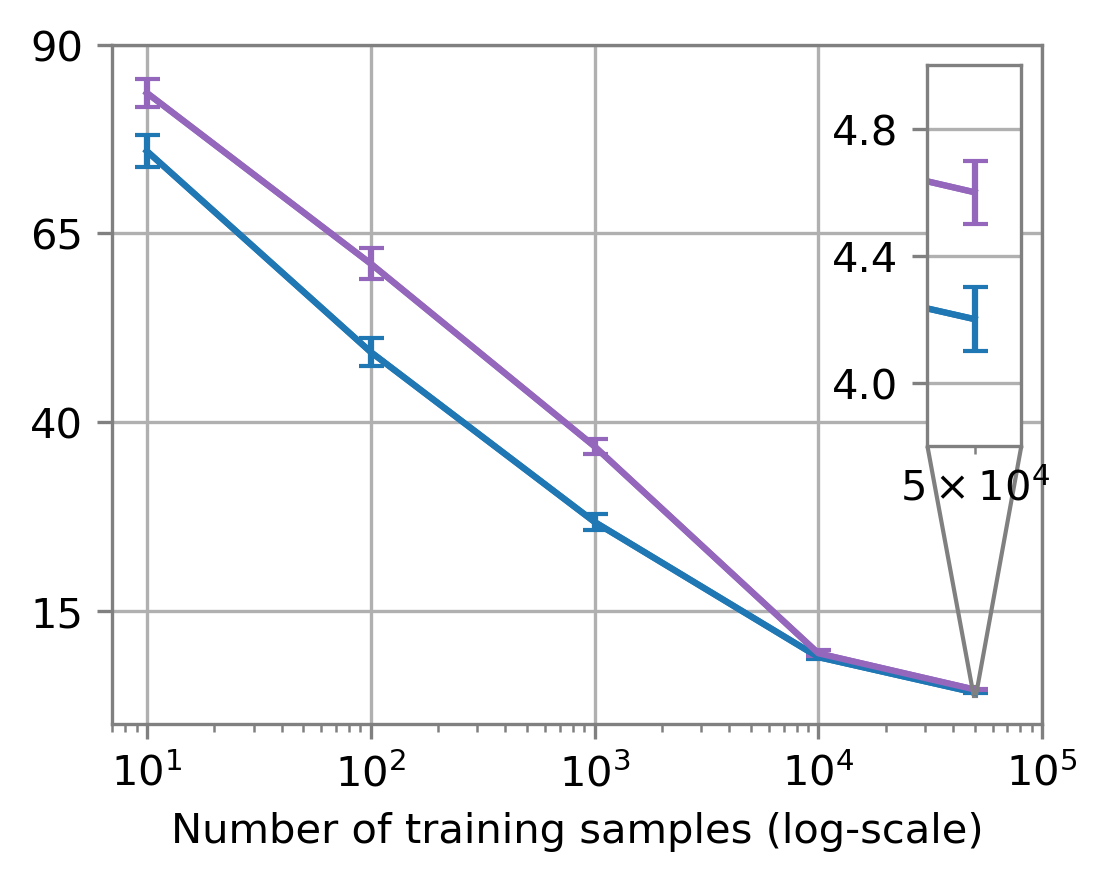

In [2]:
def color_ax(ax, color='gray'):
    ax.grid()
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(which='both', color=color)
    
def plot_figure_4a(ax):
    # Reported values in Pre-Train Your Loss
    ax.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
    ax.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    ax.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], label='SGD Transfer Init', color='#9467bd')
    ax.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    # Zoomed section
    axins = zoomed_inset_axes(ax, zoom=42, loc='upper right')
    axins.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
    axins.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    axins.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], label='SGD Transfer Init', color='#9467bd')
    axins.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    axins.set_xlim([49425, 50575])
    axins.set_ylim([3.8, 5.0])
    axins.set_yticks([4.0, 4.4, 4.8])
    axins.set_xscale('log')
    color_ax(axins)
    mark_inset(ax, axins, loc1=3, loc2=4, color='gray')
    # Formatting
    ax.set_xlim([7, 1e5])
    ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
    ax.set_yticks([15, 40, 65, 90])
    ax.set_xscale('log')
    color_ax(ax)
    ax.set_xlabel('Number of training samples (log-scale)')
    #ax.set_ylabel('Test error')
    #ax.legend(loc='lower left', fontsize='small')
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
plot_figure_4a(ax)
plt.show()

In [3]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_nll(df):
    return df.val_or_test_nll.values[-1]

def get_val_acc(df):
    return df.val_or_test_acc.values[-1]

def get_last_epoch(df):
    return df.iloc[-1]

In [4]:
def get_best_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays):
    columns = ['lr_0', 'n', 'prior_scale', 'prior_type', 'random_state', 'val_acc', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, random_state in itertools.product(ns, random_states):
        best_val_nll = np.inf
        best_hyperparameters = None
        for lr_0, prior_scale, weight_decay in itertools.product(lr_0s, prior_scales, weight_decays):
            if prior_scale:
                model_name = '{}_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
                .format(prior_type, lr_0, n, prior_scale, random_state, weight_decay)
            else:
                model_name = '{}_lr_0={}_n={}_random_state={}_weight_decay={}'\
                .format(prior_type, lr_0, n, random_state, weight_decay)
            path =  '{}/{}.csv'.format(experiments_path, model_name)
            val_nll = get_val_nll(get_df(path))
            val_acc = get_val_acc(get_df(path))
            if val_nll < best_val_nll: best_val_nll = val_nll; best_hyperparameters = [lr_0, n, prior_scale, prior_type, random_state, val_acc, weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df

def get_results(df, experiments_path):
    columns = ['n', 'prior_scale', 'prior_type', 'random_state', 'test_acc', 'test_loss', 'test_nll', 
           'test_prior', 'train_acc', 'train_loss', 'train_nll', 'train_prior']
    results = pd.DataFrame(columns=columns)
    for row_index, row in df.iterrows():
        if row.prior_scale:
            model_name = '{}_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
            .format(row.prior_type, row.lr_0, row.n, row.prior_scale, row.random_state, row.weight_decay)
        else:
            model_name = '{}_lr_0={}_n={}_random_state={}_weight_decay={}'\
            .format(row.prior_type, row.lr_0, row.n, row.random_state, row.weight_decay)
        path =  '{}/{}.csv'.format(experiments_path, model_name)
        last_epoch = get_last_epoch(get_df(path))
        results_row = [int(row.n), row.prior_scale, row.prior_type, int(row.random_state), 
                       last_epoch.val_or_test_acc, last_epoch.val_or_test_loss, 
                       last_epoch.val_or_test_nll, last_epoch.val_or_test_prior, 
                       last_epoch.train_acc, last_epoch.train_loss, 
                       last_epoch.train_nll, last_epoch.train_prior]
        results.loc[results.shape[0]] = results_row
    return results

In [5]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10_Copy1'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_scales = [None]
prior_type = 'nonlearned'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
nonlearned_hyperparameters = get_best_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays)
nonlearned_hyperparameters

,lr_0,n,prior_scale,prior_type,random_state,val_acc,weight_decay
0,0.0100,10,None,nonlearned,1001,0.0000,0.01000
1,0.0001,10,None,nonlearned,2001,0.0000,0.01000
2,0.0010,10,None,nonlearned,3001,0.0000,0.01000
3,0.0100,100,None,nonlearned,1001,0.7000,0.00000
4,0.0010,100,None,nonlearned,2001,0.5000,0.00000
5,0.0010,100,None,nonlearned,3001,0.6500,0.00000
6,0.0001,1000,None,nonlearned,1001,0.7550,0.00010
7,0.0100,1000,None,nonlearned,2001,0.8200,0.00001
8,0.0100,1000,None,nonlearned,3001,0.8650,0.00100
9,0.0100,10000,None,nonlearned,1001,0.9265,0.00100


In [6]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10_Copy1'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_scales = [None]
prior_type = 'adapted'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
adapted_hyperparameters = get_best_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays)
adapted_hyperparameters

,lr_0,n,prior_scale,prior_type,random_state,val_acc,weight_decay
0,0.100,10,None,adapted,1001,0.0000,0.010000
1,0.100,10,None,adapted,2001,0.0000,0.010000
2,0.100,10,None,adapted,3001,0.0000,0.010000
3,0.001,100,None,adapted,1001,0.7000,0.000000
4,0.001,100,None,adapted,2001,0.5000,0.010000
5,0.001,100,None,adapted,3001,0.6500,0.000001
6,0.100,1000,None,adapted,1001,0.8350,0.010000
7,0.100,1000,None,adapted,2001,0.8150,0.010000
8,0.010,1000,None,adapted,3001,0.9100,0.000010
9,0.100,10000,None,adapted,1001,0.9335,0.010000


In [7]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10_Copy1'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
wandb_project = 'retrained_CIFAR-10'
count = -1
for row_index, row in adapted_hyperparameters.iterrows():
    if row.prior_scale:
        model_name = '{}_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
        .format(row.prior_type, row.lr_0, row.n, row.prior_scale, row.random_state, row.weight_decay)
        if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
            count += 1
            print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --prior_type=\'{}\' --random_state={} --wandb --wandb_project=\'{}\' --weight_decay={}"'\
                  .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_scale, row.prior_type, int(row.random_state), wandb_project, row.weight_decay))
    else:
        model_name = '{}_lr_0={}_n={}_random_state={}_weight_decay={}'\
        .format(row.prior_type, row.lr_0, row.n, row.random_state, row.weight_decay)
        if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
            count += 1
            print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_type=\'{}\' --random_state={} --wandb --wandb_project=\'{}\' --weight_decay={}"'\
                  .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_type, int(row.random_state), wandb_project, row.weight_decay))
print(count)

-1


In [8]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10_Copy1'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
prior_scales = np.logspace(0, 9, num=10)
prior_type = 'learned'
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
learned_hyperparameters = get_best_hyperparameters(experiments_path, lr_0s, ns, prior_scales, prior_type, random_states, weight_decays)
learned_hyperparameters

,lr_0,n,prior_scale,prior_type,random_state,val_acc,weight_decay
0,0.010,10,1.000000e+06,learned,1001,0.0000,0.010000
1,0.010,10,1.000000e+05,learned,2001,0.0000,0.010000
2,0.010,10,1.000000e+05,learned,3001,0.0000,0.010000
3,0.010,100,1.000000e+00,learned,1001,0.8500,0.000100
4,0.010,100,1.000000e+02,learned,2001,0.6000,0.000000
5,0.001,100,1.000000e+09,learned,3001,0.6500,0.000000
6,0.010,1000,1.000000e+00,learned,1001,0.8450,0.000001
7,0.100,1000,1.000000e+00,learned,2001,0.8600,0.000001
8,0.100,1000,1.000000e+03,learned,3001,0.8800,0.000000
9,0.010,10000,1.000000e+01,learned,1001,0.9355,0.001000


In [9]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
wandb_project = 'retrained_CIFAR-10'
count = -1
for row_index, row in learned_hyperparameters.iterrows():
    if row.prior_scale:
        model_name = '{}_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
        .format(row.prior_type, row.lr_0, row.n, row.prior_scale, row.random_state, row.weight_decay)
        if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
            count += 1
            print('    "python ../src/CIFAR-10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --prior_type=\'{}\' --random_state={} --wandb --wandb_project=\'{}\' --weight_decay={}"'\
                  .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_scale, row.prior_type, int(row.random_state), wandb_project, row.weight_decay))
    else:
        model_name = '{}_lr_0={}_n={}_random_state={}_weight_decay={}'\
        .format(row.prior_type, row.lr_0, row.n, row.random_state, row.weight_decay)
        if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
            count += 1
            print('    "python ../src/CIFAR-10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_type=\'{}\' --random_state={} --wandb --wandb_project=\'{}\' --weight_decay={}"'\
                  .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_type, int(row.random_state), wandb_project, row.weight_decay))
print(count)

    "python ../src/CIFAR-10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --lr_0=0.01 --model_name='learned_lr_0=0.01_n=10_prior_scale=100000.0_random_state=3001_weight_decay=0.01' --n=10 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=100000.0 --prior_type='learned' --random_state=3001 --wandb --wandb_project='retrained_CIFAR-10' --weight_decay=0.01"
    "python ../src/CIFAR-10_main.py --dataset_path='/cluster/tufts/hugheslab/eharve06/CIFAR-10' --experiments_path='/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10' --lr_0=0.01 --model_name='learned_lr_0=0.01_n=100_prior_scale=1.0_random_state=1001_weight_decay=0.0001' --n=100 --prior_path='/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior' --prior_scale=1.0 --prior_type='learned' --random_state=1001 --wandb --wandb_project='retrained_C

In [10]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10_Copy1'
nonlearned_results = get_results(nonlearned_hyperparameters, experiments_path)
adapted_results = get_results(adapted_hyperparameters, experiments_path)
learned_results = get_results(learned_hyperparameters, experiments_path)
results = pd.concat([nonlearned_results, adapted_results, learned_results])
results

,n,prior_scale,prior_type,random_state,test_acc,test_loss,test_nll,test_prior,train_acc,train_loss,train_nll,train_prior
0,10,NaN,nonlearned,1001,0.1317,3.200835,3.200835,0.000000,1.00000,1.793888e-02,0.017939,0.000000e+00
1,10,NaN,nonlearned,2001,0.2621,2.097741,2.097741,0.000000,1.00000,4.409529e-03,0.004410,0.000000e+00
2,10,NaN,nonlearned,3001,0.2669,2.124110,2.124110,0.000000,1.00000,1.155219e-03,0.001155,0.000000e+00
3,100,NaN,nonlearned,1001,0.5301,1.753938,1.753938,0.000000,1.00000,1.750569e-05,0.000018,0.000000e+00
4,100,NaN,nonlearned,2001,0.5987,1.273124,1.273124,0.000000,1.00000,2.410493e-04,0.000241,0.000000e+00
5,100,NaN,nonlearned,3001,0.5575,1.404902,1.404902,0.000000,1.00000,2.823434e-04,0.000282,0.000000e+00
6,1000,NaN,nonlearned,1001,0.7818,0.689700,0.689700,0.000000,0.99900,2.121432e-02,0.021214,0.000000e+00
7,1000,NaN,nonlearned,2001,0.8181,0.790316,0.790316,0.000000,1.00000,5.853714e-06,0.000006,0.000000e+00
8,1000,NaN,nonlearned,3001,0.8275,0.655546,0.655546,0.000000,1.00000,6.708927e-05,0.000067,0.000000e+00
9,10000,NaN,nonlearned,1001,0.9372,0.226423,0.226423,0.000000,1.00000,1.199188e-04,0.000120,0.000000e+00


In [11]:
grouped_results = results.groupby(['n', 'prior_type']).agg(lambda x: tuple(x))
columns = ['test_acc', 'train_acc']
for column in columns:
    grouped_results['{}_mean'.format(column)] = grouped_results[column].apply(lambda item: np.mean(item))
    grouped_results['{}_std'.format(column)] = grouped_results[column].apply(lambda item: np.std(item))
    grouped_results['{}_min'.format(column)] = grouped_results[column].apply(lambda item: np.min(item))
    grouped_results['{}_max'.format(column)] = grouped_results[column].apply(lambda item: np.max(item))
grouped_results = grouped_results.reset_index()
grouped_results

,n,prior_type,prior_scale,random_state,test_acc,test_loss,test_nll,test_prior,train_acc,train_loss,train_nll,train_prior,test_acc_mean,test_acc_std,test_acc_min,test_acc_max,train_acc_mean,train_acc_std,train_acc_min,train_acc_max
0,10,adapted,"(nan, nan, nan)","(1001, 2001, 3001)","(0.233900025487, 0.175599992275, 0.211699992418)","(2.250451054, 2.35190447006, 2.33144707947)","(2.24424430313, 2.34600003395, 2.32525129585)","(0.00620674947277, 0.00590441282839, 0.0061958...","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00674545066431, 0.00638013100252, 0.0066738...","(0.00053870130796, 0.000475718261441, 0.000478...","(0.00620674947277, 0.00590441282839, 0.0061958...",0.207067,0.024025,0.1756,0.2339,1.000000,0.000000,1.00000,1.00000
1,10,learned,"(1000000.0, 100000.0, 100000.0)","(1001, 2001, 3001)","(0.166000008583, 0.144299998879, 0.160399988294)","(6093.64486094, 3447.17701172, 3447.10242422)","(2.31722270813, 2.41651717567, 2.34193500595)","(-6091.32763672, -3444.76049805, -3444.76049805)","(1.00000011921, 1.00000011921, 1.00000011921)","(6091327.5, 3444760.5, 3444760.5)","(0.0179686434567, 0.0178527720273, 0.017696453...","(-6091327.5, -3444760.5, -3444760.5)",0.156900,0.009198,0.1443,0.1660,1.000000,0.000000,1.00000,1.00000
2,10,nonlearned,"(nan, nan, nan)","(1001, 2001, 3001)","(0.131699994206, 0.26210001111, 0.266899973154)","(3.20083486748, 2.09774129639, 2.12410965233)","(3.20083486748, 2.09774129639, 2.12410965233)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011921, 1.00000011921)","(0.0179388821125, 0.00440952880308, 0.00115521...","(0.0179388821125, 0.00440952880308, 0.00115521...","(0.0, 0.0, 0.0)",0.220233,0.062633,0.1317,0.2669,1.000000,0.000000,1.00000,1.00000
3,100,adapted,"(nan, nan, nan)","(1001, 2001, 3001)","(0.547600030899, 0.598200023174, 0.555999994278)","(1.49662000179, 1.32835991173, 1.40695112419)","(1.49662000179, 1.30103738098, 1.40694707108)","(0.0, 0.0273224879056, 4.03778540203e-06)","(1.00000011921, 1.00000011921, 1.00000011921)","(0.000286301103188, 0.0286185126752, 0.0002961...","(0.000286301103188, 0.00129602546804, 0.000292...","(0.0, 0.0273224879056, 4.03778540203e-06)",0.567267,0.022140,0.5476,0.5982,1.000000,0.000000,1.00000,1.00000
4,100,learned,"(1.0, 100.0, 1000000000.0)","(1001, 2001, 3001)","(0.563199996948, 0.561699986458, 0.556400001049)","(-543.637831055, -491.924112793, 14204.6738187)","(1.38884101639, 1.36519425468, 1.39841315556)","(545.026672363, 493.289306641, -14203.2753906)","(1.00000011921, 1.00000011921, 1.00000011921)","(-54502.6640625, -49328.9296875, 1420327.5)","(0.00161253695842, 0.00156537583098, 0.0002852...","(54502.6640625, 49328.9296875, -1420327.5)",0.560433,0.002917,0.5564,0.5632,1.000000,0.000000,1.00000,1.00000
5,100,nonlearned,"(nan, nan, nan)","(1001, 2001, 3001)","(0.530099987984, 0.598699986935, 0.557500004768)","(1.75393823433, 1.27312405968, 1.40490223351)","(1.75393823433, 1.27312405968, 1.40490223351)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011921, 1.00000011921)","(1.75056884473e-05, 0.00024104930344, 0.000282...","(1.75056884473e-05, 0.00024104930344, 0.000282...","(0.0, 0.0, 0.0)",0.562100,0.028194,0.5301,0.5987,1.000000,0.000000,1.00000,1.00000
6,1000,adapted,"(nan, nan, nan)","(1001, 2001, 3001)","(0.816300034523, 0.820099949837, 0.820999979973)","(0.697113662529, 0.678759232903, 0.783074881363)","(0.622891067982, 0.620352584171, 0.782872887421)","(0.0742225944996, 0.0584066323936, 0.000201991...","(1.00000011921, 1.00000011921, 1.00000011921)","(0.0751252514124, 0.059254214257, 0.0002084051...","(0.000902656388469, 0.000847581742331, 6.41338...","(0.0742225944996, 0.0584066323936, 0.000201991...",0.819133,0.002037,0.8163,0.8210,1.000000,0.000000,1.00000,1.00000
7,1000,learned,"(1.0, 1.0, 1000.0)","(1001, 2001, 3001)","(0.838400006294, 0.815400004387, 0.820800065994)","(-544.45175957, -544.348691211, -165.175213672)","(0.573630697155, 0.676453542709, 0.722612887383)","(545.025390625, 545.025146484, 165.897827148)","(1.00000011921, 1.0

/cluster/tufts/rt/software/jupyter/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


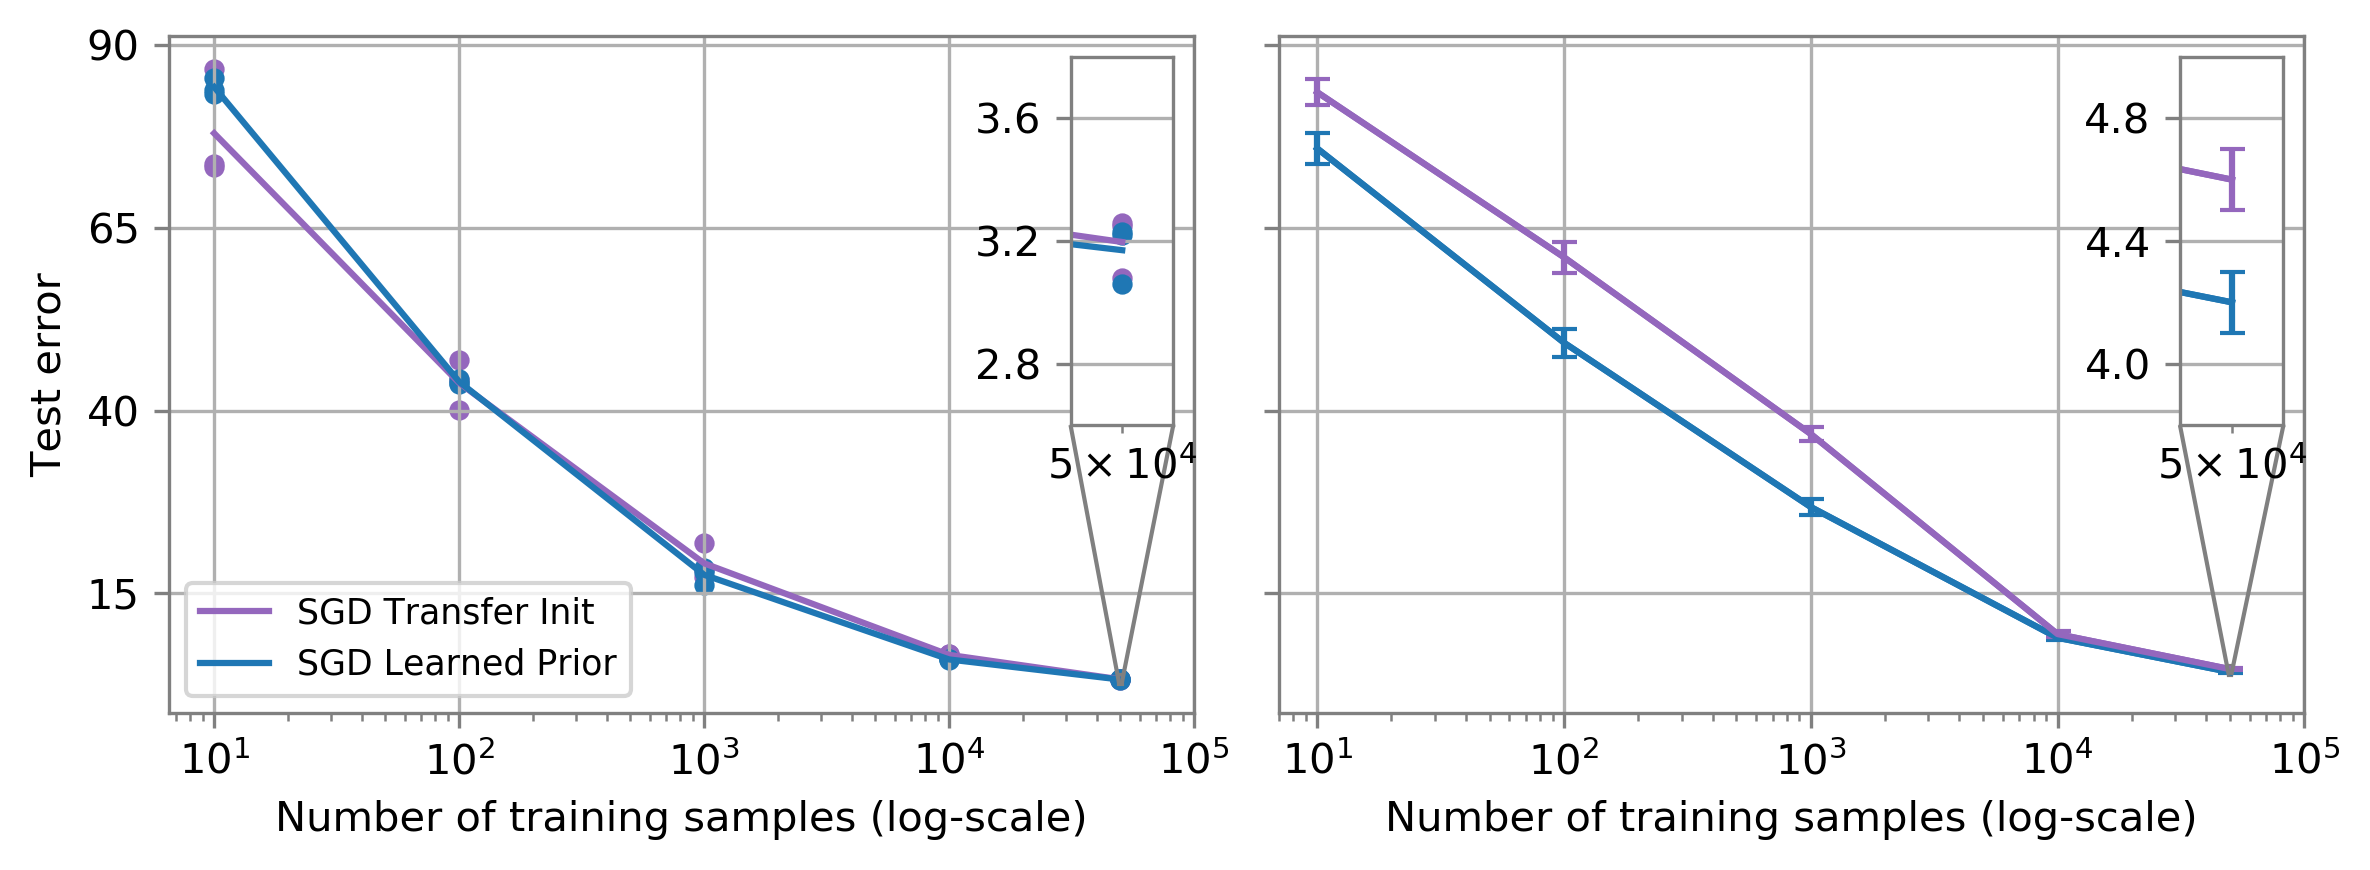

In [12]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), sharey=True, dpi=300)
axs[0].plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc_mean.values), label='SGD Transfer Init', color='#9467bd')
axs[0].scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc.values), color='#9467bd', s=15)
axs[0].plot(grouped_results[grouped_results.prior_type=='learned'].n, 100*(1-grouped_results[grouped_results.prior_type=='learned'].test_acc_mean.values), label='SGD Learned Prior', color='#1f77b4')
axs[0].scatter(results[results.prior_type=='learned'].n, 100*(1-results[results.prior_type=='learned'].test_acc.values), color='#1f77b4', s=15)
#axs[0].plot(grouped_results[grouped_results.prior_type=='adapted'].n, 100*(1-grouped_results[grouped_results.prior_type=='adapted'].test_acc_mean.values), label='SGD MAP Adaptation', color='#d62728')
#axs[0].scatter(results[results.prior_type=='adapted'].n, 100*(1-results[results.prior_type=='adapted'].test_acc.values), color='#d62728', s=15)
# Zoomed section
axins = zoomed_inset_axes(axs[0], zoom=42, loc='upper right')
axins.plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc_mean.values), color='#9467bd')
axins.scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc.values), color='#9467bd', s=15)
axins.plot(grouped_results[grouped_results.prior_type=='learned'].n, 100*(1-grouped_results[grouped_results.prior_type=='learned'].test_acc_mean.values), color='#1f77b4')
axins.scatter(results[results.prior_type=='learned'].n, 100*(1-results[results.prior_type=='learned'].test_acc.values), color='#1f77b4', s=15)
#axins.plot(grouped_results[grouped_results.prior_type=='adapted'].n, 100*(1-grouped_results[grouped_results.prior_type=='adapted'].test_acc_mean.values), color='#d62728')
#axins.scatter(results[results.prior_type=='adapted'].n, 100*(1-results[results.prior_type=='adapted'].test_acc.values), color='#d62728', s=15)
axins.set_xlim([49425, 50575])
axins.set_ylim([2.6, 3.8])
axins.set_yticks([2.8, 3.2, 3.6])
axins.set_xscale('log')
color_ax(axins)
mark_inset(axs[0], axins, loc1=3, loc2=4, color='gray')
# Formatting
axs[0].set_xscale('log')
color_ax(axs[0])
axs[0].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
axs[0].set_yticks([15, 40, 65, 90])
axs[0].set_xlabel('Number of training samples (log-scale)')
axs[0].set_ylabel('Test error')
axs[0].legend(loc='lower left', fontsize='small')
plot_figure_4a(axs[1])
fig.tight_layout()
plt.savefig('replication.pdf')
plt.show()

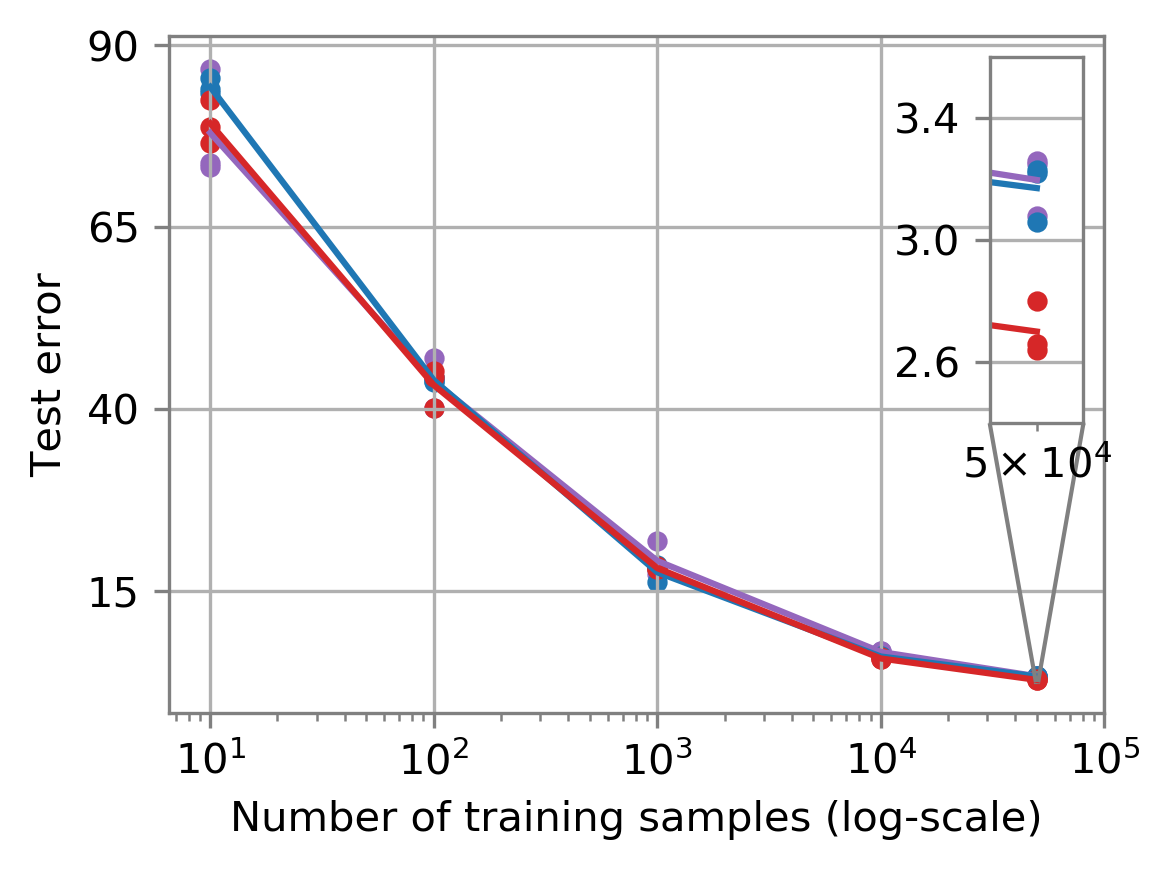

In [13]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), sharey=True, dpi=300)
ax.plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc_mean.values), label='Standard transfer learning', color='#9467bd')
ax.scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc.values), color='#9467bd', s=15)
ax.plot(grouped_results[grouped_results.prior_type=='learned'].n, 100*(1-grouped_results[grouped_results.prior_type=='learned'].test_acc_mean.values), label='Bayesian transfer learning', color='#1f77b4')
ax.scatter(results[results.prior_type=='learned'].n, 100*(1-results[results.prior_type=='learned'].test_acc.values), color='#1f77b4', s=15)
ax.plot(grouped_results[grouped_results.prior_type=='adapted'].n, 100*(1-grouped_results[grouped_results.prior_type=='adapted'].test_acc_mean.values), label='MAP Adaptation', color='#d62728')
ax.scatter(results[results.prior_type=='adapted'].n, 100*(1-results[results.prior_type=='adapted'].test_acc.values), color='#d62728', s=15)
# Zoomed section
axins = zoomed_inset_axes(ax, zoom=42, loc='upper right')
axins.plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc_mean.values), color='#9467bd')
axins.scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc.values), color='#9467bd', s=15)
axins.plot(grouped_results[grouped_results.prior_type=='learned'].n, 100*(1-grouped_results[grouped_results.prior_type=='learned'].test_acc_mean.values), color='#1f77b4')
axins.scatter(results[results.prior_type=='learned'].n, 100*(1-results[results.prior_type=='learned'].test_acc.values), color='#1f77b4', s=15)
axins.plot(grouped_results[grouped_results.prior_type=='adapted'].n, 100*(1-grouped_results[grouped_results.prior_type=='adapted'].test_acc_mean.values), color='#d62728')
axins.scatter(results[results.prior_type=='adapted'].n, 100*(1-results[results.prior_type=='adapted'].test_acc.values), color='#d62728', s=15)
axins.set_xlim([49425, 50575])
axins.set_ylim([2.4, 3.6])
axins.set_yticks([2.6, 3.0, 3.4])
axins.set_xscale('log')
color_ax(axins)
mark_inset(ax, axins, loc1=3, loc2=4, color='gray')
# Formatting
ax.set_xscale('log')
color_ax(ax)
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_yticks([15, 40, 65, 90])
ax.set_xlabel('Number of training samples (log-scale)')
ax.set_ylabel('Test error')
#ax.legend(loc='lower left', fontsize='small')
fig.tight_layout()
plt.show()

In [14]:
grouped_results[['n', 'prior_type', 'test_acc_mean', 'test_acc_min', 'test_acc_max']]

,n,prior_type,test_acc_mean,test_acc_min,test_acc_max
0,10,adapted,0.207067,0.1756,0.2339
1,10,learned,0.156900,0.1443,0.1660
2,10,nonlearned,0.220233,0.1317,0.2669
3,100,adapted,0.567267,0.5476,0.5982
4,100,learned,0.560433,0.5564,0.5632
5,100,nonlearned,0.562100,0.5301,0.5987
6,1000,adapted,0.819133,0.8163,0.8210
7,1000,learned,0.824867,0.8154,0.8384
8,1000,nonlearned,0.809133,0.7818,0.8275
9,10000,adapted,0.943433,0.9410,0.9447
